In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/analyse/')

import numpy as np
import networkx as nx
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

In [2]:
analysis_gene_names = ['PDGFRA', 'PTPRZ1', 'VCAN']
genes = dict()
for gene_name in analysis_gene_names:
    genes[gene_name] = pd.read_csv('tmp/related_genes_{}.csv'.format(gene_name))
    genes[gene_name]['value'] /= genes[gene_name]['value'].max()
    genes[gene_name]['category'] = gene_name

genes = pd.concat(list(genes.values()))
genes

,index,value,name,category
0,6429,1.000000,KCNIP4,PDGFRA
1,15794,0.808847,MALAT1,PDGFRA
2,10961,0.804236,LHFPL3,PDGFRA
3,15278,0.478197,LRRC4C,PDGFRA
4,11485,0.463631,CSMD1,PDGFRA
...,...,...,...,...
29115,23043,-0.169978,CA10,VCAN
29116,12070,-0.208728,RALYL,VCAN
29117,14609,-0.222229,ATRNL1,VCAN
29118,3295,-0.319588,LRRTM4,VCAN


In [3]:
TF = pd.read_csv('/lmh_data/data/sclab/source/Homo_sapiens_TF', sep='\t', index_col=0)
TF_cofactors = pd.read_csv('/lmh_data/data/sclab/source/Homo_sapiens_TF_cofactors', sep='\t', index_col=0)
RBP = pd.read_csv('/lmh_data/data/sclab/source/Homo_sapiens_RBP', sep='\t', index_col=0, header=None)

In [4]:
TF, TF_cofactors, RBP = TF['Symbol'].unique(), TF_cofactors['Symbol'].unique(), RBP[1].unique()
gene_names = set(TF)
# | set(TF_cofactors) | set(RBP)

In [5]:
scenic_adjacencies = pd.read_csv('/lmh_data/data/sclab/SCENIC/scenic_adjacencies_OPC.csv')

In [6]:
_gene_names = gene_names & set(genes['name'])
_adj = scenic_adjacencies[
    (scenic_adjacencies['TF'].isin(_gene_names))&(scenic_adjacencies['target'].isin(analysis_gene_names))]
x, y = [], []
for _tf_name in _gene_names:
    for _target_name in analysis_gene_names:
        _x = _adj[(_adj['TF']==_tf_name)&(_adj['target']==_target_name)]
        if _x.shape[0] == 0:
            continue
        x.append(_x['importance'].values[0])
        y.append(genes[(genes['name']==_tf_name)&(genes['category']==_target_name)]['value'].values[0])

SpearmanrResult(correlation=0.23867438078656464, pvalue=1.4501545859459283e-07)


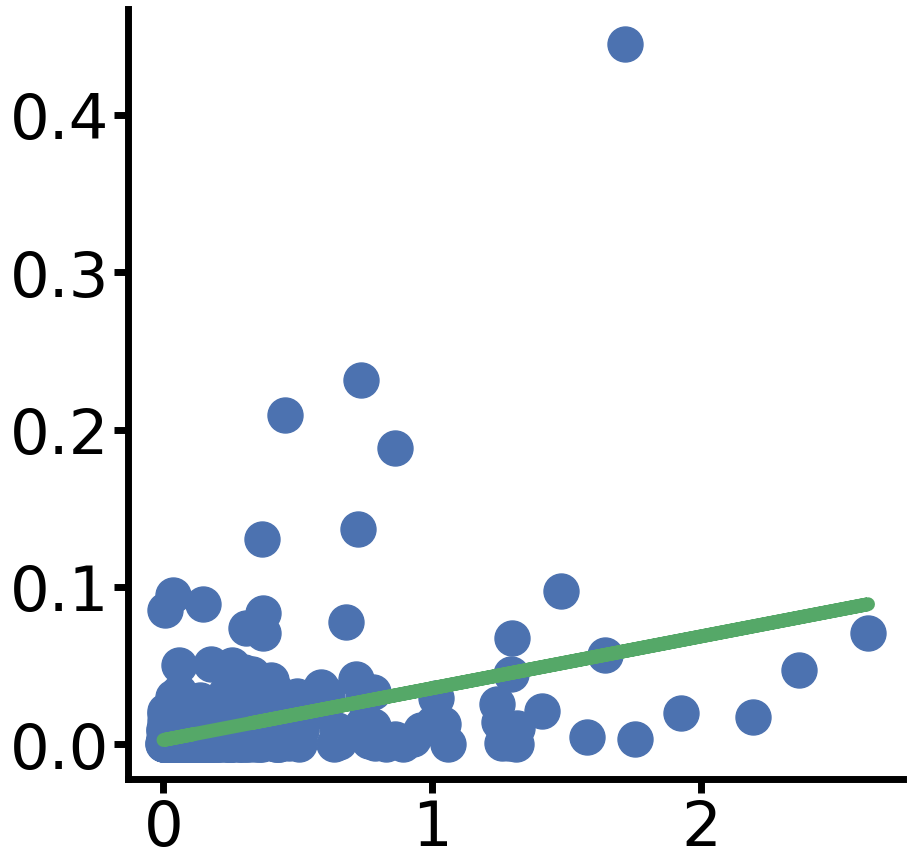

In [7]:
set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

_x, _y = np.log1p(x), [abs(i) for i in y]
parameter = np.polyfit(_x, _y, 1)
_y2 = parameter[0] * _x + parameter[1]
plt.scatter(_x, _y, s=(figure_size['large']*72./fig.dpi)**2)
plt.plot(_x, _y2, color='g', linewidth=figure_size['small'])

print(stats.spearmanr(_x, _y))

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.savefig('/lmh_data/work/SEE/analyse/figure_file/SCENIC(OPC Relevance).pdf', format='pdf', bbox_inches='tight')
plt.show()

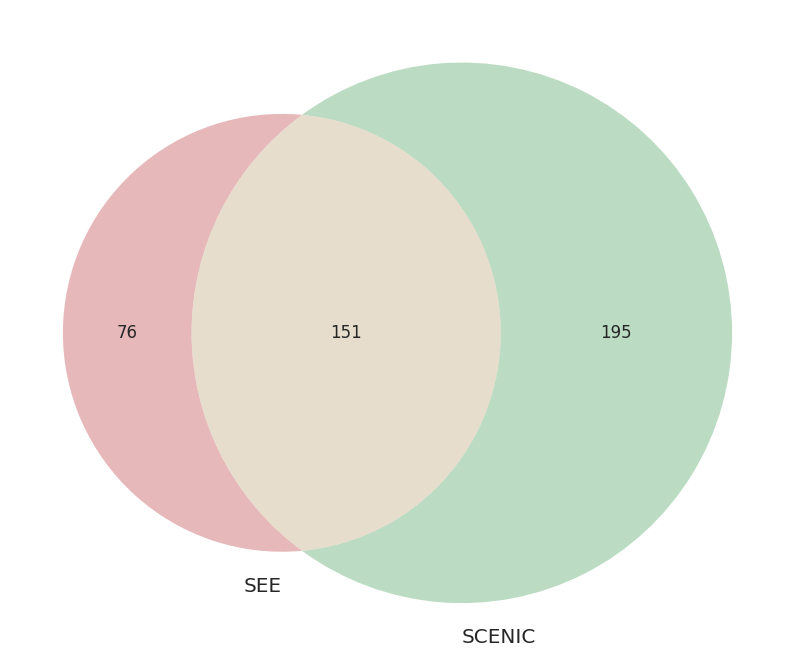

In [8]:
from matplotlib_venn import venn2

_gene_names = gene_names & set(genes['name'])
_genes = genes[genes['name'].isin(_gene_names)].copy()
_adj = scenic_adjacencies[
    (scenic_adjacencies['TF'].isin(_gene_names))&(scenic_adjacencies['target'].isin(analysis_gene_names))]

_genes['value'] = abs(_genes['value'])
predict_tf = set(_genes.sort_values('value', ascending=False).head(int(_genes.shape[0]*.1))['name'].unique())
SCENIC_tf = set(_adj.sort_values('importance', ascending=False).head(int(_genes.shape[0]*.1))['TF'].unique())

venn2(subsets = [predict_tf, SCENIC_tf], set_labels = ('SEE', 'SCENIC'))
plt.savefig('/lmh_data/work/SEE/analyse/figure_file/SCENIC(OPC venn).pdf', format='pdf', bbox_inches='tight')
plt.show()